# MAPS calculation
This script calculates MAPS for our variant classes of interest.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Load data

In [2]:
# Proportion of singletons in synonymous variant contexts
syn = pd.read_csv(
    "../outputs/proportion_singletons_synonymous_by_context.tsv",
    sep="\t",
)

In [3]:
# Limit to non-CpG contexts (see maps_model_choices.ipynb)
non_cpg = syn[syn.variant_type != "CpG"]

## Modelling

In [4]:
# Get variables for the WLS model
x = non_cpg["mu"]
X = sm.add_constant(x)
y = non_cpg["ps"]
w = non_cpg["n_obs"] # weights

In [5]:
# Fit the model
model = sm.WLS(y, X, w).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.794
Model:                            WLS   Adj. R-squared:                  0.793
No. Observations:                 176   F-statistic:                     669.7
Covariance Type:            nonrobust   Prob (F-statistic):           1.51e-61
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5557      0.003    221.100      0.000       0.551       0.561
mu         -9.873e+06   3.81e+05    -25.879      0.000   -1.06e+07   -9.12e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

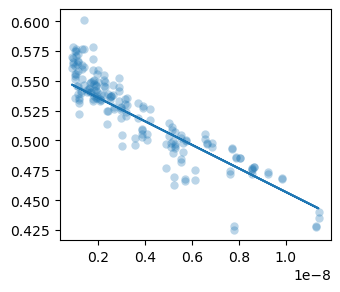

In [6]:
# Plot the data
fig, ax = plt.subplots(figsize=(3.5,3))
ax.scatter(x,y, linewidths=0, alpha=0.3)
ax.plot(x, model.predict(X))

## Calculate MAPS

In [7]:
# ...for non-CpG variants
ps = pd.read_csv("../outputs/proportion_singletons_by_csq_and_region_no_cpg.tsv", sep="\t",)

In [8]:
# Tidy the data
ps["se"] = np.sqrt((ps["ps"] * (1 - ps["ps"])) / ps["n_obs"])
ps["ps_pred"] = model.predict(sm.tools.add_constant(ps["mu"]))
ps["maps"] = np.round((ps["ps"] - ps["ps_pred"]), 3)
ps["ci95"] = 1.96 * ps["se"]
ps

,csq,mu,n_singletons,n_obs,ps,se,ps_pred,maps,ci95
0,missense,5.019917e-09,3297481,6201057,0.531761,0.000200,0.506103,0.026,0.000393
1,nonsense,4.957895e-09,117416,192416,0.610220,0.001112,0.506715,0.104,0.002179
2,synonymous,5.987558e-09,1395327,2810047,0.496549,0.000298,0.496549,0.000,0.000585
3,distal_nmd,4.823988e-09,29094,49500,0.587758,0.002212,0.508037,0.080,0.004336
4,long_exon,4.798374e-09,7895,12338,0.639893,0.004322,0.508290,0.132,0.008470
5,nmd_target,5.003376e-09,69208,111290,0.621871,0.001454,0.506266,0.116,0.002849
6,start_proximal,5.141169e-09,11219,19288,0.581657,0.003552,0.504906,0.077,0.006962


In [9]:
# Save to output
ps.to_csv("../outputs/stats_maps_non_cpg.tsv", sep="\t", index=False)